Auteur: Michaël Leroy

 Graph depuis gdf Nodes et edges
        - calcul de stats
        - classif des communes 

        .....

In [1]:
class CFG:
    data_path = './osm_datas/'
    data_path_mappers = './datas'
    path_paths = './tourism_paths'
    score_path = './tourism_scores'
    folium_path = './tourism_viz'
    area_name = 'france'

    

    

import os
os.environ['USE_PYGEOS'] = '0'

import joblib
# joblib.dump(
#     CFG, 
#     os.path.join(
#         CFG.score_path,
#         'CFG_for_tourism_score.pkl'
#     ) 
# )   


# %load_ext autoreload
# %autoreload


# %aimport OSM_helper_functions
# %aimport OCM_helper_functions

import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
from tqdm.notebook import tqdm
# from OSM_helper_functions import *
# from OCM_helper_functions import *


ox.settings.log_console=True
ox.settings.use_cache=True
''' To retrieve http data from OSMnx and cache them locally
    before building graph. Raise and exception if requests
    are all done. intercept then set to False and retry.'''
# ox.settings.cache_only_mode=True 



C:\Users\demo\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


' To retrieve http data from OSMnx and cache them locally\n    before building graph. Raise and exception if requests\n    are all done. intercept then set to False and retry.'

* 1 retrieve start cities and start_nodes from directory

In [2]:
# Mappers to link osmids to commune names


# Dict to map osmid  -> communes names
Osmid2Name = joblib.load(
    os.path.join(CFG.data_path_mappers,f'[{CFG.area_name}]mapper_osmid_to_libgeo.pkl')
)

# Dict to map communes names  -> osmid 
Name2Osmid = joblib.load(
    os.path.join(CFG.data_path_mappers,f'[{CFG.area_name}]mapper_libgeo_to_osmid.pkl')
)

In [3]:
for _, _, files in os.walk(CFG.path_paths):
    start_cities = [ file.split('_')[1][1:-1] for file in files if file.startswith('f')]
start_cities

# start_cities to start_nodes
start_nodes = [ Name2Osmid[str.upper(name)] for name in start_cities]
start_nodes

['70279',
 '114347',
 '178351',
 '102478',
 '103599',
 '105270',
 '1076124',
 '149197',
 '110866',
 '74090',
 '139610',
 '80348',
 '1215878',
 '104492',
 '107435',
 '58404',
 '114172',
 '120965',
 '76469',
 '450381',
 '28722',
 '38246',
 '52399',
 '59874',
 '170100',
 '378685',
 '147559',
 '7444',
 '162431',
 '18000',
 '132348',
 '36458',
 '54517',
 '75628',
 '117905',
 '71033',
 '35280',
 '35738',
 '76306']

* 2 Load communes scores from directory

In [4]:
scores_df = joblib.load(
    os.path.join(
        CFG.score_path,
        'Scores_qcuts.pkl'
    ))

In [5]:
scores_df.replace(0,np.nan).dropna(how='all').replace(np.nan,0).info()

<class 'pandas.core.frame.DataFrame'>
Index: 21493 entries, 153920 to 133323
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (4.0, 221.0]     21493 non-null  float64
 1   (221.0, 332.0]   21493 non-null  float64
 2   (332.0, 430.0]   21493 non-null  float64
 3   (430.0, 518.0]   21493 non-null  float64
 4   (518.0, 599.0]   21493 non-null  float64
 5   (599.0, 679.0]   21493 non-null  float64
 6   (679.0, 762.0]   21493 non-null  float64
 7   (762.0, 858.0]   21493 non-null  float64
 8   (858.0, 984.0]   21493 non-null  float64
 9   (984.0, 1603.0]  21493 non-null  float64
 10  total_count      21493 non-null  float64
dtypes: float64(11)
memory usage: 2.0+ MB


* 3 Load Communes graph

In [6]:
Nodes = joblib.load(os.path.join(CFG.data_path, f'[{CFG.area_name}]Gnodes_communes.pkl'))

# Edges = joblib.load(os.path.join(CFG.data_path, f'[{CFG.area_name}]Gedges_communes_C22.pkl'))

In [7]:
Nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 34466 entries, 2531584 to 2741108
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   y         34466 non-null  float64 
 1   x         34466 non-null  float64 
 2   codgeo    34466 non-null  object  
 3   area      34466 non-null  object  
 4   sleeping  15412 non-null  float64 
 5   visit     17923 non-null  float64 
 6   fooding   6616 non-null   float64 
 7   working   6950 non-null   float64 
 8   vehicule  4166 non-null   float64 
 9   geometry  34466 non-null  geometry
dtypes: float64(7), geometry(1), object(2)
memory usage: 3.9+ MB


In [8]:
# Edges = Edges.drop(['src_trgt'], axis=1)
# Edges = Edges.reset_index()

# Edges['u'] = Edges['u'].astype(str)
# Edges['v'] = Edges['v'].astype(str)
# Edges['key'] = Edges['key'].astype(str)

# Edges = Edges.set_index(['u','v','key'])
# PATHS = Edges.pop('path')
# # Edges.info()

In [9]:
nodes2codgeo = dict(zip(Nodes.index, Nodes['codgeo']))

In [10]:
display(Nodes.head(2))#,Edges.head(2))

,y,x,codgeo,area,sleeping,visit,fooding,working,vehicule,geometry
osmid,,,,,,,,,,
2531584,43.461438,-0.819766,64312,POLYGON ((-0.832953105776137 43.44755970632465...,2.0,NaN,NaN,NaN,NaN,POINT (-0.81977 43.46144)
279376,47.730421,0.777490,41255,POLYGON ((0.7426134063245691 47.72901158483156...,NaN,1.0,NaN,NaN,NaN,POINT (0.77749 47.73042)


In [11]:
GPS = 4326
LBT = 2154
# from shapely.geometry import Point

Nodes['point'] = Nodes.to_crs(LBT)['geometry'].apply(lambda p: list(p.coords[0]))


Nodes['x'] = Nodes['point'].apply(lambda p: p[1])
Nodes['y'] = Nodes['point'].apply(lambda p: p[0])

Nodes.head(1)

,y,x,codgeo,area,sleeping,visit,fooding,working,vehicule,geometry,point
osmid,,,,,,,,,,,
2531584,390856.452592,6.269961e+06,64312,POLYGON ((-0.832953105776137 43.44755970632465...,2.0,NaN,NaN,NaN,NaN,POINT (-0.81977 43.46144),"[390856.4525917853, 6269961.04538183]"


* 4 Create data_scores from Nodes and scores_df

In [12]:
import numpy as np

data_scores = Nodes.loc[
    scores_df.index,
        [
        'y','x',
        'sleeping',
        'visit',
        'fooding',
        'working',
        'vehicule'
        ]
]
data_scores = data_scores.replace(np.nan,0)

In [13]:
df = pd.concat(
    [
    data_scores,
    scores_df
    ],
    axis=1,
    ignore_index=False
    )
df = df.drop('total_count', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34466 entries, 2531584 to 2741108
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   y                34466 non-null  float64
 1   x                34466 non-null  float64
 2   sleeping         34466 non-null  float64
 3   visit            34466 non-null  float64
 4   fooding          34466 non-null  float64
 5   working          34466 non-null  float64
 6   vehicule         34466 non-null  float64
 7   (4.0, 221.0]     34466 non-null  int64  
 8   (221.0, 332.0]   34466 non-null  int64  
 9   (332.0, 430.0]   34466 non-null  int64  
 10  (430.0, 518.0]   34466 non-null  int64  
 11  (518.0, 599.0]   34466 non-null  int64  
 12  (599.0, 679.0]   34466 non-null  int64  
 13  (679.0, 762.0]   34466 non-null  int64  
 14  (762.0, 858.0]   34466 non-null  int64  
 15  (858.0, 984.0]   34466 non-null  int64  
 16  (984.0, 1603.0]  34466 non-null  int64  
dtypes: float6

--------------------------

# Unsupervised labelling

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.manifold import TSNE

scaler = StandardScaler(with_mean=False, with_std=False)
df_scaled = scaler.fit_transform(df.values) 

tsne = TSNE(n_components= 2,
            perplexity= 30, 
            early_exaggeration= 12,
            learning_rate= "auto", 
            n_iter= 1000, 
            n_iter_without_progress= 300, 
            min_grad_norm= 1e-7, 
            metric= "euclidean", 
            metric_params= None, 
            init= "random", 
            verbose= 0, 
            random_state= 42, 
            method= "barnes_hut", #: Literal['barnes_hut', 'exact'] 
            angle= 0.5, 
            n_jobs= 4, 
            )


X = tsne.fit_transform(df_scaled)


<AxesSubplot: xlabel='0', ylabel='1'>

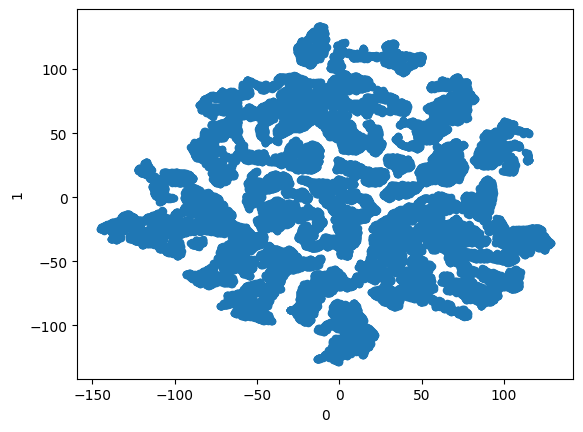

In [21]:
pd.DataFrame(X, columns=['0','1']).plot(kind='scatter',x='0',y='1')


In [16]:

dbscan = DBSCAN(
    eps=5.2,
    min_samples=30, 
    metric='euclidean', 
    metric_params=None, 
    algorithm='auto', 
    leaf_size=30, 
    p=2.5, 
    n_jobs=4).fit(X)

print(f'{len(set(dbscan.labels_))=}')
pd.DataFrame(
    np.transpose(
        np.unique(
            dbscan.labels_, 
            return_counts=True
        )
    ), 
    columns=['label', 'count']
).set_index('label').T



len(set(dbscan.labels_))=10


label,0,1,2,3,4,5,6,7,8,9
count,2955,11021,8270,8717,1051,1363,66,310,93,620


C:\Users\demo\AppData\Local\Temp\ipykernel_20492\1189916833.py:3: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  clust.plot(kind='scatter',x='0',y='1',color=clust.label.values, cmap='Accent')


<AxesSubplot: xlabel='0', ylabel='1'>

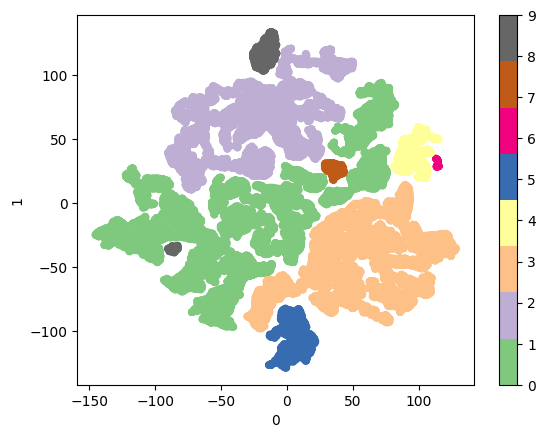

In [22]:
clust = pd.DataFrame(X, columns=['0','1'])
clust['label'] = dbscan.labels_
clust.plot(kind='scatter',x='0',y='1',color=clust.label.values, cmap='Accent')

-------------------------------------------

In [18]:
Nodes['labels'] = dbscan.labels_
Nodes['labels'] = Nodes['labels'].replace(-1,  np.nan)#.replace(0, np.nan)

personas_vars = [
        'sleeping',
        'visit',
        'fooding',
        'working',
        'vehicule'	
]
personas = Nodes[personas_vars + ['labels']]
personas = personas.replace(np.nan,0)
personas.head(1)

,sleeping,visit,fooding,working,vehicule,labels
osmid,,,,,,
2531584,2.0,0.0,0.0,0.0,0.0,0


In [19]:
personas.labels.value_counts().index

Int64Index([1, 3, 2, 0, 5, 4, 9, 7, 8, 6], dtype='int64')

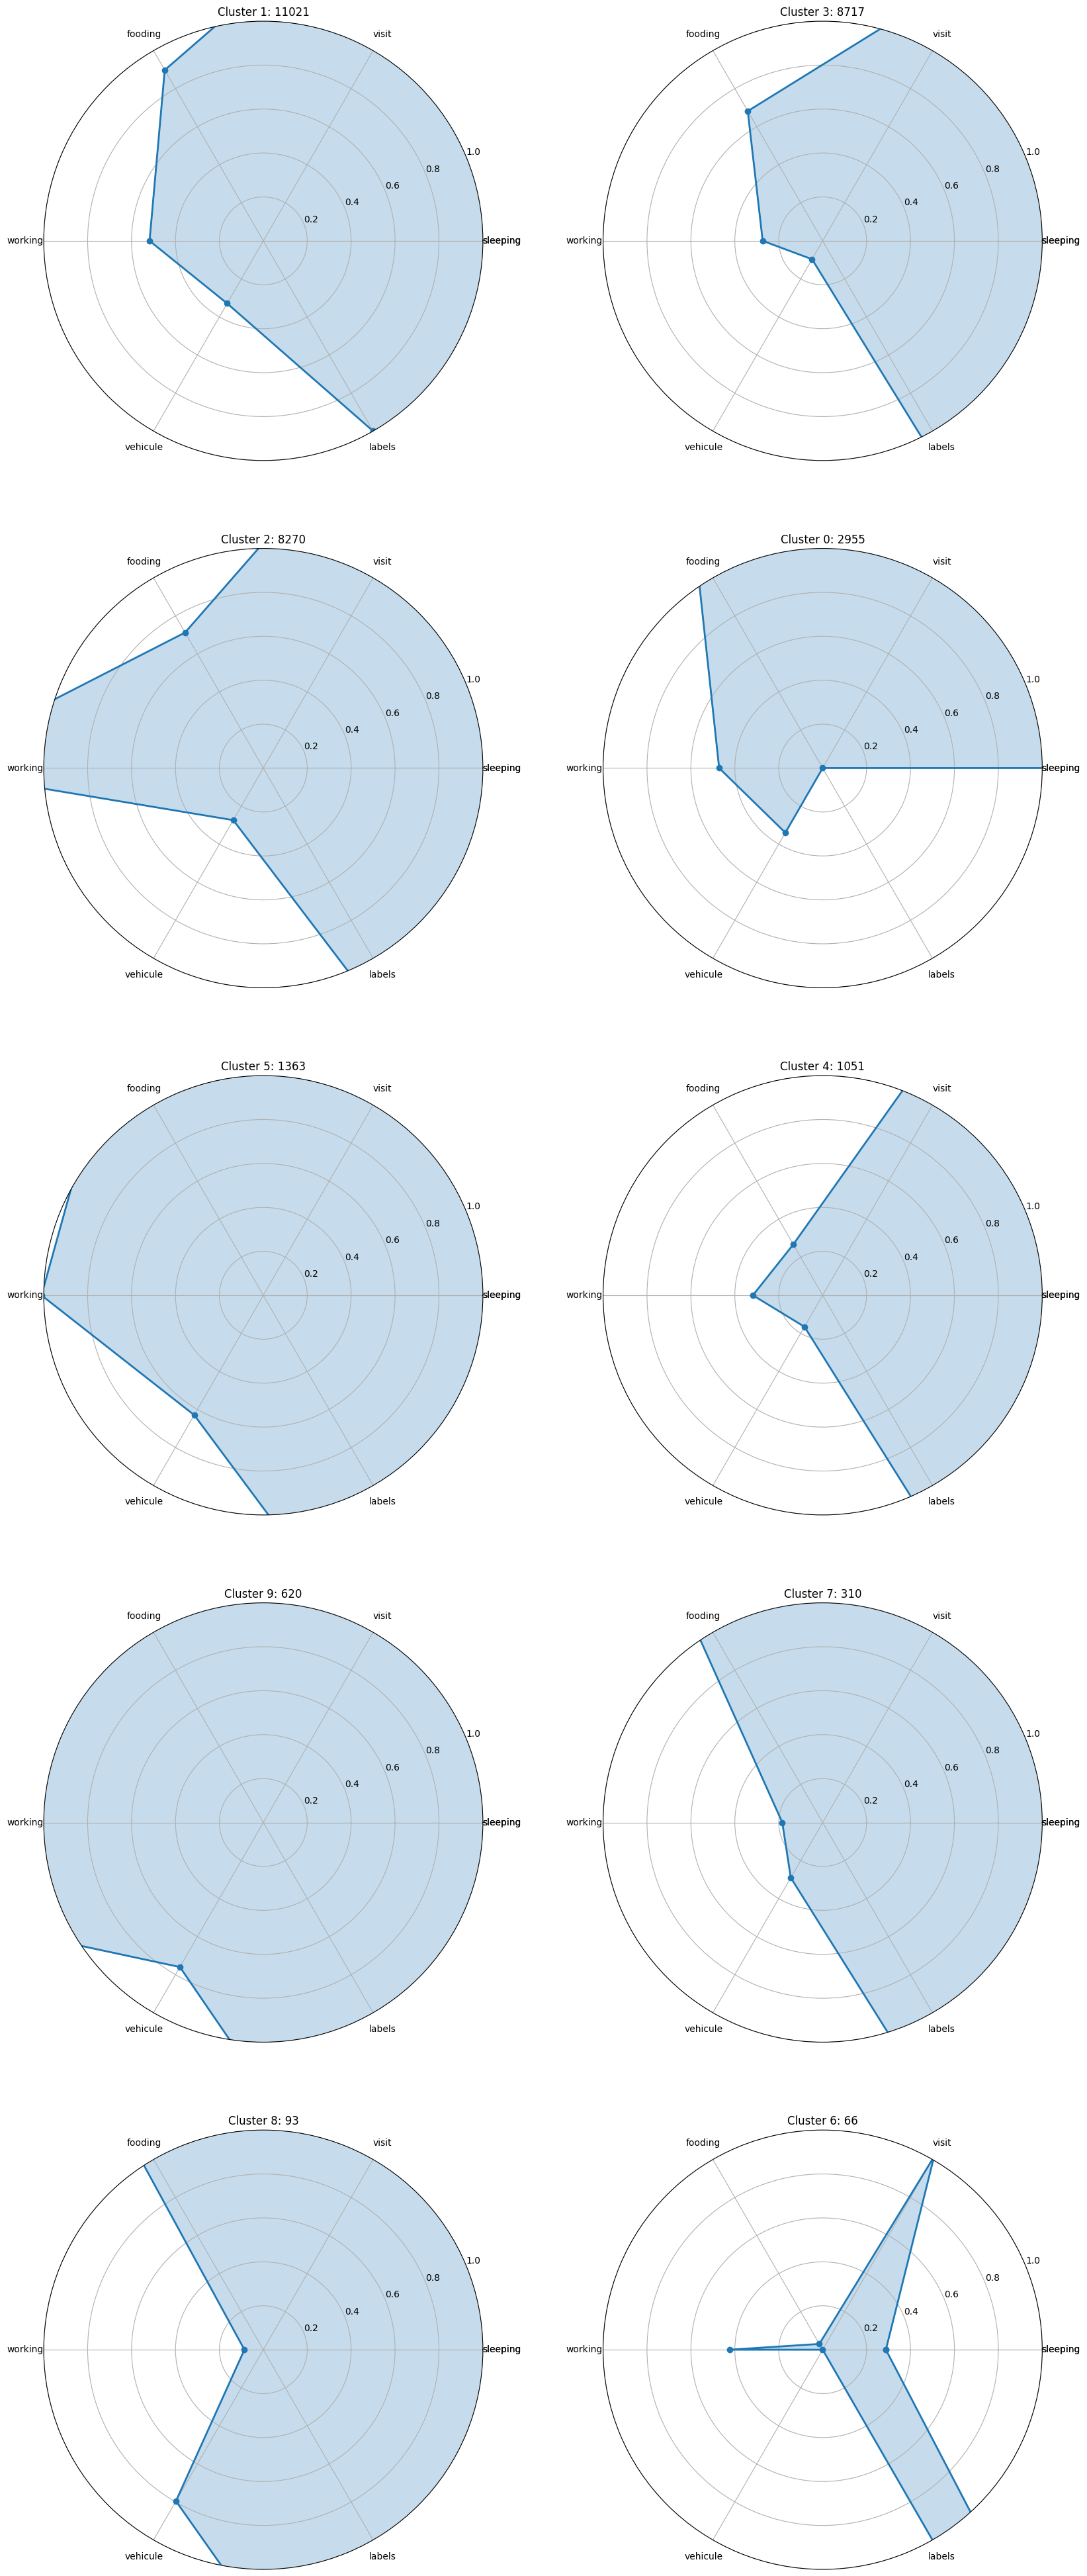

In [20]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

unique_labels = personas.labels.value_counts().index

# create a figure with multiple subplots
n_cols = 2
n_rows = round((len(unique_labels) + .5) / n_cols)
fig, axs = plt.subplots(nrows=n_rows,ncols=n_cols, figsize=(10*n_cols, 10*n_rows), subplot_kw=dict(projection='polar'))

axs = axs.flatten()

# scaler = MinMaxScaler()

# create a radar plot for each cluster
for i, label in enumerate(unique_labels):
    # get the rows of 'df' that belong to this cluster
    mask = (personas.labels == label)
    sub_df = personas[mask]
    
    # compute the mean of each variable in this cluster
    means = sub_df.mean()
    
    # create a list of variable names and values
    var_names = means.index.tolist()
    var_values = means.values
    
    # close the radar plot by repeating the first coordinate
    var_values = np.concatenate([var_values, [var_values[0]]])
    
    # create a polar axis for the current subplot
    ax = axs[i] if len(unique_labels) > 1 else axs
    
    # set the title of the subplot to the cluster label
    ax.set_title(f'Cluster {label}: {sub_df.shape[0]}')
    
    # create the radar plot for this cluster
    angles = np.linspace(0, 2*np.pi, len(var_names), endpoint=False)
    angles = np.concatenate([angles, [angles[0]]])
    ax.plot(angles, var_values, 'o-', linewidth=2)
    ax.fill(angles, var_values, alpha=0.25)
    
    # set the ticks along the radial axis
    ax.set_xticks(angles)
    var_names.append(var_names[0])
    ax.set_xticklabels(var_names)
    ax.tick_params(axis='x', pad=10)
    
    ax.set_ylim(0, 1)  # adjust the limits as needed
    ax.grid(True)

    # break

# show the plot
plt.show()
